Install all dependencies

In [1]:
!pip install tensortrade ray symfit tensorboardX

     |████████████████████████████████| 133kB 17.4MB/s 
     |████████████████████████████████| 48.5MB 68kB/s 
     |████████████████████████████████| 952kB 49.9MB/s 
     |████████████████████████████████| 317kB 19.2MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 276kB 61.0MB/s 
     |████████████████████████████████| 788kB 47.4MB/s 
     |████████████████████████████████| 13.2MB 247kB/s 
     |████████████████████████████████| 81kB 13.4MB/s 
     |████████████████████████████████| 2.9MB 39.7MB/s 
     |████████████████████████████████| 1.3MB 41.1MB/s 
     |████████████████████████████████| 204kB 58.7MB/s 
     |████████████████████████████████| 133kB 66.2MB/s 
     |████████████████████████████████| 81kB 15.6MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 5.9MB 31.8MB/s 
     |████████████████████████████████| 358kB 24.3MB/s 
     |████████████████████████████████| 143kB 53.8MB/s 

Set up the instruments

In [7]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

Create Action Scheme

In [8]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

Create Reward Scheme

In [9]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

Create Rederer

In [10]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

Train with Ray

In [11]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio



def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    coinbase = Exchange("coinbase", service=execute_order)(
        p
    )

    cash = Wallet(coinbase, 100000 * USD)
    asset = Wallet(coinbase, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

register_env("TradingEnv", create_env)

Set up training algorithm

In [12]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

Trial name,status,loc
PPO_TradingEnv_9977b_00000,RUNNING,


(pid=483) WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=483) Instructions for updating:
(pid=483) non-resource variables are not supported in the long term
(pid=483) 2021-01-07 19:21:56,551	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=504) WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=504) Instructions for updating:
(pid=504) non-resource variables are not supported in the long term
(pid=504) 2021-01-07 19:22:00,724	WARNING compression.py:16 -- lz4 not available, disabling sample compress

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-22-17
  done: false
  episode_len_mean: 207.94736842105263
  episode_reward_max: 18.230046247482576
  episode_reward_mean: 1.7599740465792753
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 19
  episodes_total: 19
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.626620588824153
        entropy_coeff: 0.01
        kl: 0.0709037920460105
        policy_loss: -0.231815867125988
        total_loss: 0.2729591040406376
        vf_explained_var: 0.0011904425919055939
        vf_loss: 0.9937208220362663
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.72857142857141
    ram_util_percent: 15

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,1,14.6437,4000,1.75997,18.23,-18.7093,207.947


(pid=483) 2021-01-07 19:22:17,053	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.2729591040406376, 'policy_loss': -0.231815867125988, 'vf_loss': 0.9937208220362663, 'vf_explained_var': 0.0011904426, 'kl': 0.0709037920460105, 'entropy': 0.626620588824153, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:17,062	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=4020, mean_mean=92.97801351779123, mean_std=27.73835987539247), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:22:24,570	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.28104948019608855, 'policy_loss': -0.2326843305490911, 'vf_loss': 0.9394572004675865, 'vf_explained_var': -0.038832974, 'kl': 0.15948874085696257, 'entropy': 0.38414094410836697, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:24,819	DEBUG sgd.py:134

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-22-31
  done: false
  episode_len_mean: 332.2916666666667
  episode_reward_max: 253.5679774349552
  episode_reward_mean: 40.42091725534053
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 5
  episodes_total: 24
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.0007000000000000001
        entropy: 0.39256164990365505
        entropy_coeff: 0.01
        kl: 0.12495199963450432
        policy_loss: -0.2673405227251351
        total_loss: 0.2010033413534984
        vf_explained_var: 0.021844081580638885
        vf_loss: 0.8695677537471056
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.7952380952

(pid=483) 2021-01-07 19:22:31,416	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.2010033413534984, 'policy_loss': -0.2673405227251351, 'vf_loss': 0.8695677537471056, 'vf_explained_var': 0.021844082, 'kl': 0.12495199963450432, 'entropy': 0.39256164990365505, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:31,425	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=8025, mean_mean=87.14804783891798, mean_std=28.756807327214815), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,2,28.9752,8000,40.4209,253.568,-18.7093,332.292


(pid=483) 2021-01-07 19:22:38,333	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.19249745827983133, 'policy_loss': -0.12459473445778713, 'vf_loss': 0.5678009567782283, 'vf_explained_var': 0.017205441, 'kl': 0.07789455997061571, 'entropy': 0.186083733337, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:38,564	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.1355948666750919, 'policy_loss': -0.12167912168661132, 'vf_loss': 0.49609463289380074, 'vf_explained_var': 0.02182317, 'kl': 0.026356698712334037, 'entropy': 0.26338389283046126, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:38,821	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.13612419937271625, 'policy_loss': -0.11673084329231642, 'vf_loss': 0.4884845335036516, 'vf_

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-22-45
  done: false
  episode_len_mean: 427.67857142857144
  episode_reward_max: 477.8473246360492
  episode_reward_mean: 100.79471173572077
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 28
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 0.00030000000000000003
        entropy: 0.2560938666574657
        entropy_coeff: 0.01
        kl: 0.030265348963439465
        policy_loss: -0.13340603886172175
        total_loss: 0.11565333104226738
        vf_explained_var: 0.05004756152629852
        vf_loss: 0.4760017963126302
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.5800

(pid=483) 2021-01-07 19:22:45,249	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.11565333104226738, 'policy_loss': -0.13340603886172175, 'vf_loss': 0.4760017963126302, 'vf_explained_var': 0.05004756, 'kl': 0.030265348963439465, 'entropy': 0.2560938666574657, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:45,258	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=12029, mean_mean=84.50406279093339, mean_std=28.87510030293121), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,3,42.7735,12000,100.795,477.847,-18.7093,427.679


(pid=483) 2021-01-07 19:22:52,136	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.1065454492054414, 'policy_loss': -0.07469347590813413, 'vf_loss': 0.33048194320872426, 'vf_explained_var': 0.019559242, 'kl': 0.0259620291715138, 'entropy': 0.15264168148860335, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:52,365	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.07886223278183024, 'policy_loss': -0.08774829626781866, 'vf_loss': 0.31492394814267755, 'vf_explained_var': 0.030999057, 'kl': 0.016102354536997154, 'entropy': 0.17205340135842562, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:52,602	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.06949853608966805, 'policy_loss': -0.09293871908448637, 'vf_loss': 0.314541136380285, 'vf_explained_var': 0.033811405, 'kl': 0.010

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-22-59
  done: false
  episode_len_mean: 499.21875
  episode_reward_max: 524.4613691028192
  episode_reward_mean: 152.74260785408143
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 32
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.800000000000001e-05
        entropy: 0.19292846834287047
        entropy_coeff: 0.01
        kl: 0.010716728342231363
        policy_loss: -0.0987901123589836
        total_loss: 0.06021436006994918
        vf_explained_var: 0.04193396866321564
        vf_loss: 0.3073999285697937
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.821052631578944
    ram_util

(pid=483) 2021-01-07 19:22:59,054	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.06021436006994918, 'policy_loss': -0.0987901123589836, 'vf_loss': 0.3073999285697937, 'vf_explained_var': 0.04193397, 'kl': 0.010716728342231363, 'entropy': 0.19292846834287047, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:22:59,064	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=16033, mean_mean=83.19133497576196, mean_std=28.830399878839657), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,4,56.5493,16000,152.743,524.461,-18.7093,499.219


(pid=504) 2021-01-07 19:23:02,810	INFO sampler.py:559 -- Raw obs from env: { 0: { 'agent0': np.ndarray((25, 5), dtype=float32, min=-0.011, max=111.448, mean=61.611)}}
(pid=504) 2021-01-07 19:23:02,812	INFO sampler.py:560 -- Info return from env: {0: {'agent0': {'net_worth': 131471.13, 'step': 226}}}
(pid=504) 2021-01-07 19:23:02,812	INFO sampler.py:1023 -- Preprocessed obs: np.ndarray((25, 5), dtype=float32, min=-0.011, max=111.448, mean=61.611)
(pid=504) 2021-01-07 19:23:02,812	INFO sampler.py:1028 -- Filtered obs: np.ndarray((25, 5), dtype=float64, min=-1.494, max=0.284, mean=-0.84)
(pid=504) 2021-01-07 19:23:02,812	WARNING deprecation.py:30 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=504) 2021-01-07 19:23:02,813	INFO sampler.py:1300 -- Inputs to compute_actions():
(pid=504) 
(pid=504) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=504)                                   'env_id': 0,
(

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-23-13
  done: false
  episode_len_mean: 554.8611111111111
  episode_reward_max: 554.4986079077503
  episode_reward_mean: 196.91708024503558
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 36
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.400000000000001e-05
        entropy: 0.1401898697949946
        entropy_coeff: 0.01
        kl: 0.007005844352534041
        policy_loss: -0.06672326507396065
        total_loss: 0.03305173280386953
        vf_explained_var: 0.04250344634056091
        vf_loss: 0.19289590022526681
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.223809523809514
   

(pid=483) 2021-01-07 19:23:13,304	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.03305173280386953, 'policy_loss': -0.06672326507396065, 'vf_loss': 0.19289590022526681, 'vf_explained_var': 0.042503446, 'kl': 0.007005844352534041, 'entropy': 0.1401898697949946, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,5,70.7679,20000,196.917,554.499,-18.7093,554.861


(pid=483) 2021-01-07 19:23:13,315	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=20037, mean_mean=82.40325278338297, mean_std=28.771496016066685), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:23:20,009	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.029890196747146547, 'policy_loss': -0.04897368571255356, 'vf_loss': 0.14961214386858046, 'vf_explained_var': 0.030674178, 'kl': 0.007337917419493863, 'entropy': 0.08952865074388683, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:20,243	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.028635252034291625, 'policy_loss': -0.05214718286879361, 'vf_loss': 0.1536493229214102, 'vf_explained_var': 0.03404089, 'kl': 0.007123950927052647, 'entropy': 0.08508938644081354, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:20,494	DEBUG sgd.py:134 -- 2 {'allreduce_

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-23-27
  done: false
  episode_len_mean: 599.375
  episode_reward_max: 568.8605288334868
  episode_reward_mean: 233.43488085399235
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 40
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.0e-05
        entropy: 0.10431637358851731
        entropy_coeff: 0.01
        kl: 0.004331283817009535
        policy_loss: -0.06247923121554777
        total_loss: 0.011615399445872754
        vf_explained_var: 0.014552459120750427
        vf_loss: 0.14442835905356333
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.83684210526315
    ram_util_percent: 15.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,6,84.5658,24000,233.435,568.861,-18.7093,599.375


(pid=483) 2021-01-07 19:23:27,146	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=24041, mean_mean=81.87767889750415, mean_std=28.718873807244076), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:23:33,681	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.6e-05, 'total_loss': 0.021754316898295656, 'policy_loss': -0.03654879366513342, 'vf_loss': 0.11371535179205239, 'vf_explained_var': 0.0013071541, 'kl': 0.00612396461044825, 'entropy': 0.062140246969647706, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:33,946	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.6e-05, 'total_loss': 0.011200937362445984, 'policy_loss': -0.048651825229171664, 'vf_loss': 0.11372602841584012, 'vf_explained_var': 0.022343444, 'kl': 0.010230622516246513, 'entropy': 0.046308765187859535, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:34,219	DEBUG sgd.py:134 -- 2 {

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-23-40
  done: false
  episode_len_mean: 635.7954545454545
  episode_reward_max: 577.7427799176385
  episode_reward_mean: 264.2035430041454
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 44
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.6e-05
        entropy: 0.07527736853808165
        entropy_coeff: 0.01
        kl: 0.005747230799897807
        policy_loss: -0.05276307585882023
        total_loss: 0.004399202443892136
        vf_explained_var: 0.010135505348443985
        vf_loss: 0.11195072185364552
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.05499999999999
    ram_util_pe

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,7,98.376,28000,264.204,577.743,-18.7093,635.795


(pid=483) 2021-01-07 19:23:40,976	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.6e-05, 'total_loss': 0.004399202443892136, 'policy_loss': -0.05276307585882023, 'vf_loss': 0.11195072185364552, 'vf_explained_var': 0.010135505, 'kl': 0.005747230799897807, 'entropy': 0.07527736853808165, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:40,987	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=28045, mean_mean=81.50217795432881, mean_std=28.674735661852278), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:23:47,398	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': 0.010044232883956283, 'policy_loss': -0.027052968798670918, 'vf_loss': 0.07326460447802674, 'vf_explained_var': -0.061413147, 'kl': 0.00292394465238853, 'entropy': 0.05219343223143369, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:23:47,633	DEBUG sgd.py:134 -- 1 {'

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-23-54
  done: false
  episode_len_mean: 666.1458333333334
  episode_reward_max: 586.9638572359659
  episode_reward_mean: 290.7886988651773
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 48
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.2e-05
        entropy: 0.05196511757094413
        entropy_coeff: 0.01
        kl: 0.003331960557261482
        policy_loss: -0.038322268170304596
        total_loss: -0.003932780935429037
        vf_explained_var: -0.0756651982665062
        vf_loss: 0.06756920159023139
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.915789473684214
    ram_util_

(pid=483) 2021-01-07 19:23:54,294	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': -0.003932780935429037, 'policy_loss': -0.038322268170304596, 'vf_loss': 0.06756920159023139, 'vf_explained_var': -0.0756652, 'kl': 0.003331960557261482, 'entropy': 0.05196511757094413, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,8,111.66,32000,290.789,586.964,-18.7093,666.146


(pid=483) 2021-01-07 19:23:54,308	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=32049, mean_mean=81.2205024519768, mean_std=28.638041696758908), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:24:00,852	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.8e-05, 'total_loss': 0.009470873133977875, 'policy_loss': -0.018470354727469385, 'vf_loss': 0.05570323600113625, 'vf_explained_var': -0.10380787, 'kl': 0.002325718860886887, 'entropy': 0.03028546110726893, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:01,082	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.8e-05, 'total_loss': -0.0016985089314403012, 'policy_loss': -0.030003737949300557, 'vf_loss': 0.05545067598723108, 'vf_explained_var': -0.081993, 'kl': 0.004748851322801784, 'entropy': 0.022147815790958703, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:01,315	DEBUG sgd.py:134 -- 2 

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-24-07
  done: false
  episode_len_mean: 691.8269230769231
  episode_reward_max: 593.6393984199631
  episode_reward_mean: 313.427234320065
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 52
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 7.8e-05
        entropy: 0.03262743301456794
        entropy_coeff: 0.01
        kl: 0.0036521069232549053
        policy_loss: -0.028249944414710626
        total_loss: 0.0008817588095553219
        vf_explained_var: -0.0267537459731102
        vf_loss: 0.05768336854089284
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.78947368421053
    ram_util_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,9,125.133,36000,313.427,593.639,-18.7093,691.827


(pid=483) 2021-01-07 19:24:07,803	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.8e-05, 'total_loss': 0.0008817588095553219, 'policy_loss': -0.028249944414710626, 'vf_loss': 0.05768336854089284, 'vf_explained_var': -0.026753746, 'kl': 0.0036521069232549053, 'entropy': 0.03262743301456794, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:07,813	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=36053, mean_mean=81.00139199061545, mean_std=28.607369701546283), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=504) 2021-01-07 19:24:07,841	INFO sampler.py:1300 -- Inputs to compute_actions():
(pid=504) 
(pid=504) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=504)                                   'env_id': 0,
(pid=504)                                   'info': { 'net_worth': 122310.51394983551,
(pid=504)                                             'step': 25},
(pid=504)                 

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-24-21
  done: false
  episode_len_mean: 713.8392857142857
  episode_reward_max: 598.0581881031342
  episode_reward_mean: 333.54451829917025
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 56
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.084375
        cur_lr: 7.400000000000001e-05
        entropy: 0.019732942077098414
        entropy_coeff: 0.01
        kl: 0.0030829027309664525
        policy_loss: -0.020107861382712144
        total_loss: -0.011067717758123763
        vf_explained_var: -0.37260907888412476
        vf_loss: 0.01795470955039491
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.16000000

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,10,138.625,40000,333.545,598.058,-18.7093,713.839


(pid=483) 2021-01-07 19:24:21,326	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.400000000000001e-05, 'total_loss': -0.011067717758123763, 'policy_loss': -0.020107861382712144, 'vf_loss': 0.01795470955039491, 'vf_explained_var': -0.37260908, 'kl': 0.0030829027309664525, 'entropy': 0.019732942077098414, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:21,335	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=40057, mean_mean=80.82608502363908, mean_std=28.58148611399427), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:24:27,942	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 7.000000000000001e-05, 'total_loss': 0.02124534352333285, 'policy_loss': 0.013337846467038617, 'vf_loss': 0.016108711387460062, 'vf_explained_var': -0.3872527, 'kl': 0.0004741356395025751, 'entropy': 0.016685938113369048, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 1

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-24-35
  done: false
  episode_len_mean: 732.9166666666666
  episode_reward_max: 598.0581881031342
  episode_reward_mean: 351.0238439367369
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 60
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0421875
        cur_lr: 7.000000000000001e-05
        entropy: 0.006265661497309338
        entropy_coeff: 0.01
        kl: 0.002860929016605951
        policy_loss: -0.00733050936833024
        total_loss: 0.0008891100878827274
        vf_explained_var: -0.39389777183532715
        vf_loss: 0.01632316030372749
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restore: 11
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.2526315789

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,11,152.363,44000,351.024,598.058,-18.7093,732.917


(pid=483) 2021-01-07 19:24:35,091	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0421875, 'cur_lr': 7.000000000000001e-05, 'total_loss': 0.0008891100878827274, 'policy_loss': -0.00733050936833024, 'vf_loss': 0.01632316030372749, 'vf_explained_var': -0.39389777, 'kl': 0.002860929016605951, 'entropy': 0.006265661497309338, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:35,103	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=44061, mean_mean=80.6826397527556, mean_std=28.55941713738777), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:24:41,435	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.6e-05, 'total_loss': 0.07005751739052357, 'policy_loss': 0.06312844686908647, 'vf_loss': 0.013324668921995908, 'vf_explained_var': -0.46213248, 'kl': 0.01581813854244518, 'entropy': 0.006693651113891974, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:41,682	DEBUG

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-24-48
  done: false
  episode_len_mean: 749.609375
  episode_reward_max: 598.0759164220572
  episode_reward_mean: 366.41416695166663
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 64
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.02109375
        cur_lr: 6.6e-05
        entropy: 0.004279161716112867
        entropy_coeff: 0.01
        kl: 0.0019215294732930488
        policy_loss: -0.01094892920809798
        total_loss: -0.005722513858927414
        vf_explained_var: -0.5138664245605469
        vf_loss: 0.010457347216288326
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.085
    ram_util_percent: 15

(pid=483) 2021-01-07 19:24:48,915	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.02109375, 'cur_lr': 6.6e-05, 'total_loss': -0.005722513858927414, 'policy_loss': -0.01094892920809798, 'vf_loss': 0.010457347216288326, 'vf_explained_var': -0.5138664, 'kl': 0.0019215294732930488, 'entropy': 0.004279161716112867, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:48,925	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=48065, mean_mean=80.56309357121437, mean_std=28.540412453271916), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,12,166.152,48000,366.414,598.076,-18.7093,749.609


(pid=483) 2021-01-07 19:24:55,562	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 6.2e-05, 'total_loss': 0.00722529340418987, 'policy_loss': 0.0033573008549865335, 'vf_loss': 0.007818763335308176, 'vf_explained_var': -0.5993094, 'kl': 0.00013511047285227125, 'entropy': 0.004281106368580367, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:55,791	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 6.2e-05, 'total_loss': -0.0012907114287372679, 'policy_loss': -0.005123370647197589, 'vf_loss': 0.007739209810097236, 'vf_explained_var': -0.5258888, 'kl': 0.00024556485462312594, 'entropy': 0.003952991566620767, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:24:56,038	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 6.2e-05, 'total_loss': -0.0036643789790105075, 'policy_loss': -0.007514947035815567, 'vf_loss': 0.007778558482641529, 'vf_explained_var': -0.5810001, 'kl': 0.0003198

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-25-02
  done: false
  episode_len_mean: 764.3382352941177
  episode_reward_max: 598.0788713456138
  episode_reward_mean: 380.0198033780103
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 68
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.010546875
        cur_lr: 6.2e-05
        entropy: 0.002944788037439139
        entropy_coeff: 0.01
        kl: 0.0013076452212317236
        policy_loss: -0.00888434714943287
        total_loss: -0.005082903098809766
        vf_explained_var: -0.6105037927627563
        vf_loss: 0.00763420044859231
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.699999999999996
    ra

(pid=483) 2021-01-07 19:25:02,542	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.010546875, 'cur_lr': 6.2e-05, 'total_loss': -0.005082903098809766, 'policy_loss': -0.00888434714943287, 'vf_loss': 0.00763420044859231, 'vf_explained_var': -0.6105038, 'kl': 0.0013076452212317236, 'entropy': 0.002944788037439139, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:02,551	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=52069, mean_mean=80.46193310520025, mean_std=28.52389507359213), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,13,179.74,52000,380.02,598.079,-18.7093,764.338


(pid=504) 2021-01-07 19:25:08,205	INFO sampler.py:1023 -- Preprocessed obs: np.ndarray((25, 5), dtype=float32, min=0.009, max=103.45, mean=63.013)
(pid=504) 2021-01-07 19:25:08,205	INFO sampler.py:1028 -- Filtered obs: np.ndarray((25, 5), dtype=float64, min=-1.2, max=1.555, mean=-0.217)
(pid=504) 2021-01-07 19:25:08,205	WARNING deprecation.py:30 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=504) 2021-01-07 19:25:08,205	INFO sampler.py:1300 -- Inputs to compute_actions():
(pid=504) 
(pid=504) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=504)                                   'env_id': 0,
(pid=504)                                   'info': { 'net_worth': 917163.891309539,
(pid=504)                                             'step': 671},
(pid=504)                                   'obs': np.ndarray((25, 5), dtype=float64, min=-1.2, max=1.555, mean=-0.217),
(pid=504)                      

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-25-16
  done: false
  episode_len_mean: 777.4305555555555
  episode_reward_max: 598.0966004794773
  episode_reward_mean: 392.13448332104815
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 72
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0052734375
        cur_lr: 5.8e-05
        entropy: 0.0028861096434411593
        entropy_coeff: 0.01
        kl: 0.0005666589020876245
        policy_loss: -0.01592191113741137
        total_loss: -0.01182828939636238
        vf_explained_var: -0.5703625679016113
        vf_loss: 0.008238988822085958
    num_steps_sampled: 56000
    num_steps_trained: 56000
  iterations_since_restore: 14
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.19499999999999
    

(pid=483) 2021-01-07 19:25:16,218	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0052734375, 'cur_lr': 5.8e-05, 'total_loss': -0.01182828939636238, 'policy_loss': -0.01592191113741137, 'vf_loss': 0.008238988822085958, 'vf_explained_var': -0.57036257, 'kl': 0.0005666589020876245, 'entropy': 0.0028861096434411593, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:16,227	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=56073, mean_mean=80.37521975298138, mean_std=28.50941846284081), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,14,193.384,56000,392.134,598.097,-18.7093,777.431


(pid=483) 2021-01-07 19:25:22,671	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.4000000000000005e-05, 'total_loss': -0.00356633683986729, 'policy_loss': -0.005071651059552096, 'vf_loss': 0.0030570586957310297, 'vf_explained_var': -0.70883083, 'kl': 0.0015390953327111571, 'entropy': 0.002727195775605651, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:22,916	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.4000000000000005e-05, 'total_loss': -0.0069311410043155774, 'policy_loss': -0.00836339860688895, 'vf_loss': 0.002926710688825551, 'vf_explained_var': -0.6528642, 'kl': 0.001256881192370246, 'entropy': 0.00344112691391274, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:23,149	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.4000000000000005e-05, 'total_loss': -0.006105043892603135, 'policy_loss': -0.007521483657910721, 'vf_loss': 0.002879637851492589,

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-25-29
  done: false
  episode_len_mean: 789.1447368421053
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 402.974866914068
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 76
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00263671875
        cur_lr: 5.4000000000000005e-05
        entropy: 0.002580257414820153
        entropy_coeff: 0.01
        kl: 0.0002991761592774367
        policy_loss: -0.008924872861825861
        total_loss: -0.007529394679295365
        vf_explained_var: -0.6494836807250977
        vf_loss: 0.002840989310243458
    num_steps_sampled: 60000
    num_steps_trained: 60000
  iterations_since_restore: 15
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.9421

(pid=483) 2021-01-07 19:25:29,707	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00263671875, 'cur_lr': 5.4000000000000005e-05, 'total_loss': -0.007529394679295365, 'policy_loss': -0.008924872861825861, 'vf_loss': 0.002840989310243458, 'vf_explained_var': -0.6494837, 'kl': 0.0002991761592774367, 'entropy': 0.002580257414820153, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:29,715	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=60077, mean_mean=80.3000649094192, mean_std=28.49663372405096), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,15,206.837,60000,402.975,598.108,-18.7093,789.145


(pid=483) 2021-01-07 19:25:36,429	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 5e-05, 'total_loss': 0.021302592067513615, 'policy_loss': 0.019865632959408686, 'vf_loss': 0.002912923543362922, 'vf_explained_var': -0.7095313, 'kl': 0.011250884324734142, 'entropy': 0.003433354762591989, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:36,692	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 5e-05, 'total_loss': 0.02146790856932057, 'policy_loss': 0.02001316301902989, 'vf_loss': 0.0029232579936433467, 'vf_explained_var': -0.71656036, 'kl': 0.013500348148927088, 'entropy': 0.0024679170701347175, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:36,924	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 5e-05, 'total_loss': 0.01733534107916057, 'policy_loss': 0.015884227643255144, 'vf_loss': 0.002935097592398961, 'vf_explained_var': -0.6538023, 'kl': 0.00708297389292

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-25-43
  done: false
  episode_len_mean: 799.6875
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 412.7310644063376
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 80
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.001318359375
        cur_lr: 5.0e-05
        entropy: 0.002991853387925403
        entropy_coeff: 0.01
        kl: 0.06869278384570698
        policy_loss: 0.07913034065131797
        total_loss: 0.08209756798896706
        vf_explained_var: -0.7183941006660461
        vf_loss: 0.0058131909656822245
    num_steps_sampled: 64000
    num_steps_trained: 64000
  iterations_since_restore: 16
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.15
    ram_util_percent: 15.5
 

(pid=483) 2021-01-07 19:25:43,410	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.001318359375, 'cur_lr': 5e-05, 'total_loss': 0.08209756798896706, 'policy_loss': 0.07913034065131797, 'vf_loss': 0.0058131909656822245, 'vf_explained_var': -0.7183941, 'kl': 0.06869278384570698, 'entropy': 0.002991853387925403, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,16,220.508,64000,412.731,598.108,-18.7093,799.688


(pid=483) 2021-01-07 19:25:43,419	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=64081, mean_mean=80.23430192908087, mean_std=28.485265347842837), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:25:49,922	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0019775390625000003, 'cur_lr': 4.6e-05, 'total_loss': 0.016013452812330797, 'policy_loss': -0.0034535370068624616, 'vf_loss': 0.03899497757447534, 'vf_explained_var': -0.010978818, 'kl': 4.168291665532925e-05, 'entropy': 0.00305835286940237, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:50,203	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0019775390625000003, 'cur_lr': 4.6e-05, 'total_loss': 0.009987289144191891, 'policy_loss': -0.008002764137927443, 'vf_loss': 0.036029398383107036, 'vf_explained_var': 0.07024058, 'kl': 0.0004113654614773532, 'entropy': 0.0025457744002324034, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 1

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-25-57
  done: false
  episode_len_mean: 809.2261904761905
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 421.5375597408041
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 84
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0019775390625000003
        cur_lr: 4.6e-05
        entropy: 0.002864510089466421
        entropy_coeff: 0.01
        kl: 0.03799512119803694
        policy_loss: -0.029643832589499652
        total_loss: -0.01467863202560693
        vf_explained_var: 0.11980155855417252
        vf_loss: 0.029837416273949202
    num_steps_sampled: 68000
    num_steps_trained: 68000
  iterations_since_restore: 17
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.0
    ram_uti

(pid=483) 2021-01-07 19:25:57,190	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0019775390625000003, 'cur_lr': 4.6e-05, 'total_loss': -0.01467863202560693, 'policy_loss': -0.029643832589499652, 'vf_loss': 0.029837416273949202, 'vf_explained_var': 0.11980156, 'kl': 0.03799512119803694, 'entropy': 0.002864510089466421, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:25:57,206	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=68085, mean_mean=80.17627383816824, mean_std=28.47509344609365), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,17,234.261,68000,421.538,598.108,-18.7093,809.226


(pid=483) 2021-01-07 19:26:03,842	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0029663085937500005, 'cur_lr': 4.2e-05, 'total_loss': 0.01394776173401624, 'policy_loss': 0.005919387564063072, 'vf_loss': 0.016113502064399654, 'vf_explained_var': -0.38105223, 'kl': 0.0001222024582918607, 'entropy': 0.0028736861136167136, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:04,065	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0029663085937500005, 'cur_lr': 4.2e-05, 'total_loss': -0.010746274259872735, 'policy_loss': -0.01690795665490441, 'vf_loss': 0.012378071505736443, 'vf_explained_var': -0.3936006, 'kl': 0.0009452993518155317, 'entropy': 0.0030159274938341696, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:04,295	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0029663085937500005, 'cur_lr': 4.2e-05, 'total_loss': -0.0114819947630167, 'policy_loss': -0.01736967923352495, 'vf_loss': 0.011829197606857633, 'vf_explained_var': -0.

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-26-11
  done: false
  episode_len_mean: 817.8977272727273
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 429.5617618722747
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 88
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0029663085937500005
        cur_lr: 4.2e-05
        entropy: 0.003523356924915788
        entropy_coeff: 0.01
        kl: 0.0014498174721992996
        policy_loss: -0.004088512301677838
        total_loss: 0.0027637792809400707
        vf_explained_var: -0.37595123052597046
        vf_loss: 0.01376645642449148
    num_steps_sampled: 72000
    num_steps_trained: 72000
  iterations_since_restore: 18
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.89
    ram

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,18,248.134,72000,429.562,598.108,-18.7093,817.898


(pid=483) 2021-01-07 19:26:11,103	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0029663085937500005, 'cur_lr': 4.2e-05, 'total_loss': 0.0027637792809400707, 'policy_loss': -0.004088512301677838, 'vf_loss': 0.01376645642449148, 'vf_explained_var': -0.37595123, 'kl': 0.0014498174721992996, 'entropy': 0.003523356924915788, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:11,113	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=72089, mean_mean=80.12469179245015, mean_std=28.465940708812273), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=504) 2021-01-07 19:26:11,143	INFO sampler.py:1300 -- Inputs to compute_actions():
(pid=504) 
(pid=504) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=504)                                   'env_id': 0,
(pid=504)                                   'info': { 'net_worth': 122310.51394983551,
(pid=504)                                             'step': 25},
(pid=504)   

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-26-24
  done: false
  episode_len_mean: 825.8152173913044
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 436.8891066076178
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 92
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0014831542968750003
        cur_lr: 3.8e-05
        entropy: 0.0029486418502528977
        entropy_coeff: 0.01
        kl: 0.0009038562885343993
        policy_loss: -0.014608313795179129
        total_loss: -0.011215992082725279
        vf_explained_var: -0.6109943389892578
        vf_loss: 0.0068409377975058305
    num_steps_sampled: 76000
    num_steps_trained: 76000
  iterations_since_restore: 19
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.35
    r

(pid=483) 2021-01-07 19:26:24,733	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0014831542968750003, 'cur_lr': 3.8e-05, 'total_loss': -0.011215992082725279, 'policy_loss': -0.014608313795179129, 'vf_loss': 0.0068409377975058305, 'vf_explained_var': -0.61099434, 'kl': 0.0009038562885343993, 'entropy': 0.0029486418502528977, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:24,742	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=76093, mean_mean=80.07853822270368, mean_std=28.457662761638428), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,19,261.732,76000,436.889,598.108,-18.7093,825.815


(pid=483) 2021-01-07 19:26:31,141	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0007415771484375001, 'cur_lr': 3.4e-05, 'total_loss': 0.009375516412546858, 'policy_loss': 0.006536131506436504, 'vf_loss': 0.005731985771944892, 'vf_explained_var': -0.60219705, 'kl': 0.00023000069353598798, 'entropy': 0.002678194732652628, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:31,369	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0007415771484375001, 'cur_lr': 3.4e-05, 'total_loss': 0.016573279133808683, 'policy_loss': 0.013838564589605085, 'vf_loss': 0.005516913732435569, 'vf_explained_var': -0.5776321, 'kl': 0.0004107979237036874, 'entropy': 0.0024046382068263483, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:31,600	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0007415771484375001, 'cur_lr': 3.4e-05, 'total_loss': 0.01268613804859342, 'policy_loss': 0.009964321812731214, 'vf_loss': 0.005495931283803657, 'vf_explained_var': -0.

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-26-38
  done: false
  episode_len_mean: 833.0729166666666
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 443.6059008525947
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 96
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0007415771484375001
        cur_lr: 3.4e-05
        entropy: 0.0021042804269768567
        entropy_coeff: 0.01
        kl: 0.0003449598833675793
        policy_loss: -0.007511742020142265
        total_loss: -0.0048491682900930755
        vf_explained_var: -0.6003426313400269
        vf_loss: 0.005366731105425515
    num_steps_sampled: 80000
    num_steps_trained: 80000
  iterations_since_restore: 20
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.83157894

(pid=483) 2021-01-07 19:26:38,179	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.0007415771484375001, 'cur_lr': 3.4e-05, 'total_loss': -0.0048491682900930755, 'policy_loss': -0.007511742020142265, 'vf_loss': 0.005366731105425515, 'vf_explained_var': -0.60034263, 'kl': 0.0003449598833675793, 'entropy': 0.0021042804269768567, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:38,191	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=80097, mean_mean=80.03699903035627, mean_std=28.45014097203213), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,20,275.146,80000,443.606,598.108,-18.7093,833.073


(pid=483) 2021-01-07 19:26:44,777	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00037078857421875007, 'cur_lr': 2.9999999999999997e-05, 'total_loss': -0.0023562339338241145, 'policy_loss': -0.003766802532481961, 'vf_loss': 0.0028646997901660143, 'vf_explained_var': -0.7103831, 'kl': 0.0005925822273879326, 'entropy': 0.0021999597683759475, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:45,005	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00037078857421875007, 'cur_lr': 2.9999999999999997e-05, 'total_loss': -0.0033622293558437377, 'policy_loss': -0.004750362510094419, 'vf_loss': 0.0028215226205929866, 'vf_explained_var': -0.75941116, 'kl': 0.0006560373548152934, 'entropy': 0.002287150437098262, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:45,231	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00037078857421875007, 'cur_lr': 2.9999999999999997e-05, 'total_loss': -0.0031602755771018565, 'policy_loss': -0.00457310947240330

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-26-51
  done: false
  episode_len_mean: 839.75
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 449.7857356820279
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 100
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00037078857421875007
        cur_lr: 2.9999999999999997e-05
        entropy: 0.002133570219939429
        entropy_coeff: 0.01
        kl: 0.0008272424727544525
        policy_loss: -0.008036073690163903
        total_loss: -0.00667042878922075
        vf_explained_var: -0.6486083269119263
        vf_loss: 0.00277334632437487
    num_steps_sampled: 84000
    num_steps_trained: 84000
  iterations_since_restore: 21
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.984210

(pid=483) 2021-01-07 19:26:51,521	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00037078857421875007, 'cur_lr': 2.9999999999999997e-05, 'total_loss': -0.00667042878922075, 'policy_loss': -0.008036073690163903, 'vf_loss': 0.00277334632437487, 'vf_explained_var': -0.6486083, 'kl': 0.0008272424727544525, 'entropy': 0.002133570219939429, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:51,530	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=84101, mean_mean=79.99941515188519, mean_std=28.443277028572098), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,21,288.447,84000,449.786,598.108,-18.7093,839.75


(pid=483) 2021-01-07 19:26:57,859	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00018539428710937503, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.005063159842393361, 'policy_loss': -0.00732535121642286, 'vf_loss': 0.004566599800796212, 'vf_explained_var': -0.63687813, 'kl': 0.0014661168956460002, 'entropy': 0.002137857743150562, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:58,094	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00018539428710937503, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.006601534521905705, 'policy_loss': -0.008847710094414651, 'vf_loss': 0.004534823022595447, 'vf_explained_var': -0.63609475, 'kl': 0.0035228511262395124, 'entropy': 0.002188788285678811, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:26:58,322	DEBUG sgd.py:134 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00018539428710937503, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.006497860384115484, 'policy_loss': -0.008748578205995727, 'vf_lo

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-27-04
  done: false
  episode_len_mean: 871.19
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 473.4209357839533
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 104
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00018539428710937503
        cur_lr: 2.600000000000001e-05
        entropy: 0.0021495298248339623
        entropy_coeff: 0.01
        kl: 0.0011136982220467107
        policy_loss: -0.01050159907026682
        total_loss: -0.00824607361573726
        vf_explained_var: -0.5774037837982178
        vf_loss: 0.004553632692477549
    num_steps_sampled: 88000
    num_steps_trained: 88000
  iterations_since_restore: 22
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.105263

(pid=483) 2021-01-07 19:27:04,992	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.00018539428710937503, 'cur_lr': 2.600000000000001e-05, 'total_loss': -0.00824607361573726, 'policy_loss': -0.01050159907026682, 'vf_loss': 0.004553632692477549, 'vf_explained_var': -0.5774038, 'kl': 0.0011136982220467107, 'entropy': 0.0021495298248339623, 'entropy_coeff': 0.01}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,22,301.883,88000,473.421,598.108,-18.7093,871.19


(pid=483) 2021-01-07 19:27:05,003	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=88105, mean_mean=79.96524733037799, mean_std=28.436988814722742), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=483) 2021-01-07 19:27:11,488	DEBUG sgd.py:134 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.269714355468752e-05, 'cur_lr': 2.1999999999999993e-05, 'total_loss': -0.002338791782676708, 'policy_loss': -0.0037721081025665626, 'vf_loss': 0.0029043824707741805, 'vf_explained_var': -0.65330476, 'kl': 0.0009757240208454398, 'entropy': 0.0018965290292669579, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:27:11,758	DEBUG sgd.py:134 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.269714355468752e-05, 'cur_lr': 2.1999999999999993e-05, 'total_loss': -0.004013882324215956, 'policy_loss': -0.005420235014753416, 'vf_loss': 0.0028575199113447525, 'vf_explained_var': -0.760639, 'kl': 0.0026239574880496386, 'entropy': 0.0022648754686827033, 'entropy_c

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-27-18
  done: false
  episode_len_mean: 903.17
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 497.5867494198667
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 108
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 9.269714355468752e-05
        cur_lr: 2.1999999999999993e-05
        entropy: 0.002403776983754824
        entropy_coeff: 0.01
        kl: 0.001584572274907492
        policy_loss: -0.008435905354417628
        total_loss: -0.007025924638583092
        vf_explained_var: -0.6831551790237427
        vf_loss: 0.002867740737826807
    num_steps_sampled: 92000
    num_steps_trained: 92000
  iterations_since_restore: 23
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.870000

(pid=483) 2021-01-07 19:27:18,842	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 9.269714355468752e-05, 'cur_lr': 2.1999999999999993e-05, 'total_loss': -0.007025924638583092, 'policy_loss': -0.008435905354417628, 'vf_loss': 0.002867740737826807, 'vf_explained_var': -0.6831552, 'kl': 0.001584572274907492, 'entropy': 0.002403776983754824, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:27:18,850	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=92109, mean_mean=79.93405007542376, mean_std=28.43120723651396), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,23,315.698,92000,497.587,598.108,-18.7093,903.17


(pid=504) 2021-01-07 19:27:18,884	INFO sampler.py:1300 -- Inputs to compute_actions():
(pid=504) 
(pid=504) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=504)                                   'env_id': 0,
(pid=504)                                   'info': { 'net_worth': 122310.51394983551,
(pid=504)                                             'step': 25},
(pid=504)                                   'obs': np.ndarray((25, 5), dtype=float64, min=-0.97, max=1.349, mean=0.118),
(pid=504)                                   'prev_action': 1,
(pid=504)                                   'prev_reward': 0.8430872411459234,
(pid=504)                                   'rnn_state': []},
(pid=504)                         'type': 'PolicyEvalData'}]}
(pid=504) 
(pid=504) 2021-01-07 19:27:18,887	INFO sampler.py:1318 -- Outputs of compute_actions():
(pid=504) 
(pid=504) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=504)                       [],
(p

Result for PPO_TradingEnv_9977b_00000:
  custom_metrics: {}
  date: 2021-01-07_19-27-32
  done: true
  episode_len_mean: 934.5
  episode_reward_max: 598.1084201445985
  episode_reward_mean: 521.0542721728383
  episode_reward_min: -18.709283875096176
  episodes_this_iter: 4
  episodes_total: 112
  experiment_id: 42bfded0599b475a850ebced11010015
  hostname: 3e6011e693cc
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 4.634857177734376e-05
        cur_lr: 1.8000000000000004e-05
        entropy: 0.0021531895645097165
        entropy_coeff: 0.01
        kl: 0.0007632322493680704
        policy_loss: -0.013510051183402538
        total_loss: -0.010136319557204843
        vf_explained_var: -0.5703884363174438
        vf_loss: 0.006790456822841406
    num_steps_sampled: 96000
    num_steps_trained: 96000
  iterations_since_restore: 24
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.373684

(pid=483) 2021-01-07 19:27:32,362	DEBUG sgd.py:134 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 4.634857177734376e-05, 'cur_lr': 1.8000000000000004e-05, 'total_loss': -0.010136319557204843, 'policy_loss': -0.013510051183402538, 'vf_loss': 0.006790456822841406, 'vf_explained_var': -0.57038844, 'kl': 0.0007632322493680704, 'entropy': 0.0021531895645097165, 'entropy_coeff': 0.01}
(pid=483) 2021-01-07 19:27:32,371	DEBUG trainer.py:534 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=96113, mean_mean=79.9054521318808, mean_std=28.425873760068797), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,RUNNING,172.28.0.2:483,24,329.184,96000,521.054,598.108,-18.7093,934.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_9977b_00000,TERMINATED,,24,329.184,96000,521.054,598.108,-18.7093,934.5


2021-01-07 19:27:32,625	INFO tune.py:448 -- Total run time: 339.07 seconds (338.86 seconds for the tuning loop).


Restore the agent

In [13]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(metric="episode_reward_mean", mode='max'),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

(pid=595) WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=595) Instructions for updating:
(pid=595) non-resource variables are not supported in the long term
(pid=595) 2021-01-07 19:27:52,697	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=595) 2021-01-07 19:27:53,933	DEBUG rollout_worker.py:1047 -- Creating policy for default_policy
(pid=595) 2021-01-07 19:27:53,934	DEBUG catalog.py:496 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f12d1433be0>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
(pid=595) 2021-01-07 19:27:53,947	INFO torch_policy.py:110 -- TorchPolicy running on CPU.
2021-01-07 19:27:53,981	DEBUG rollout_worker.py:1047 -- Creating 

Visualize agents decisions

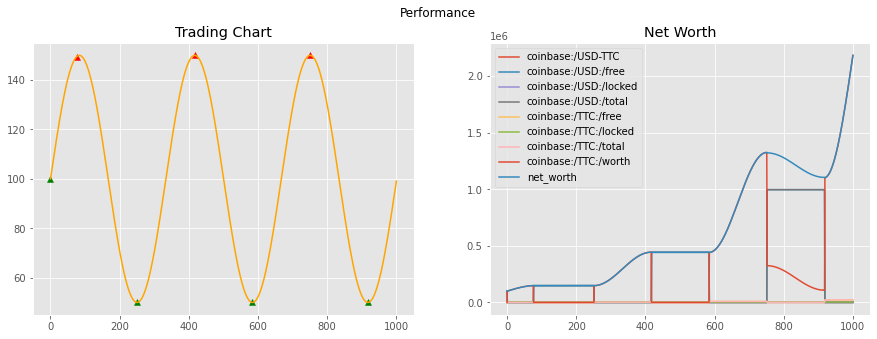

In [14]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()